In [1]:
!pip install ipywidgets 
!pip install jupyterlab==4.2.1 jupyter==1.0.0 jupyter_client==8.6.0 jupyterlab_widgets==3.0.11 

   ---------------------------------------- 0.0/139.8 kB ? eta -:--:--
   ---------------------------------------- 139.8/139.8 kB 4.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/214.4 kB ? eta -:--:--
   --------------------------------------- 214.4/214.4 kB 12.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ----------------------- ---------------- 1.4/2.3 MB 41.9 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 29.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os 
from IPython.display import display, clear_output, Image 
import ipywidgets as widgets 
from PIL import Image as IMG
from transformers import BlipProcessor, BlipForConditionalGeneration, AutoProcessor, AutoModelForCausalLM,  ViTImageProcessor

In [4]:
DATA_PATHS = {
    "annotated_set_dir": "prompts/",
    "inference_set_dir": "complete_image_set/inference/"
}

#### Exploring ipywidgets

In [3]:
# Set up to present captions as buttons and retrieve the selected caption text  
string_list = ["Option 1", "Option 2", "Option 3"]

def on_tile_clicked(b):
    print("You clicked:", b.description)

tiles = []
for string in string_list:
    tile = widgets.Button(description=string, layout=widgets.Layout(width='auto'))
    tile.on_click(on_tile_clicked)
    tiles.append(tile)

tile_container = widgets.HBox(tiles)
display(tile_container)

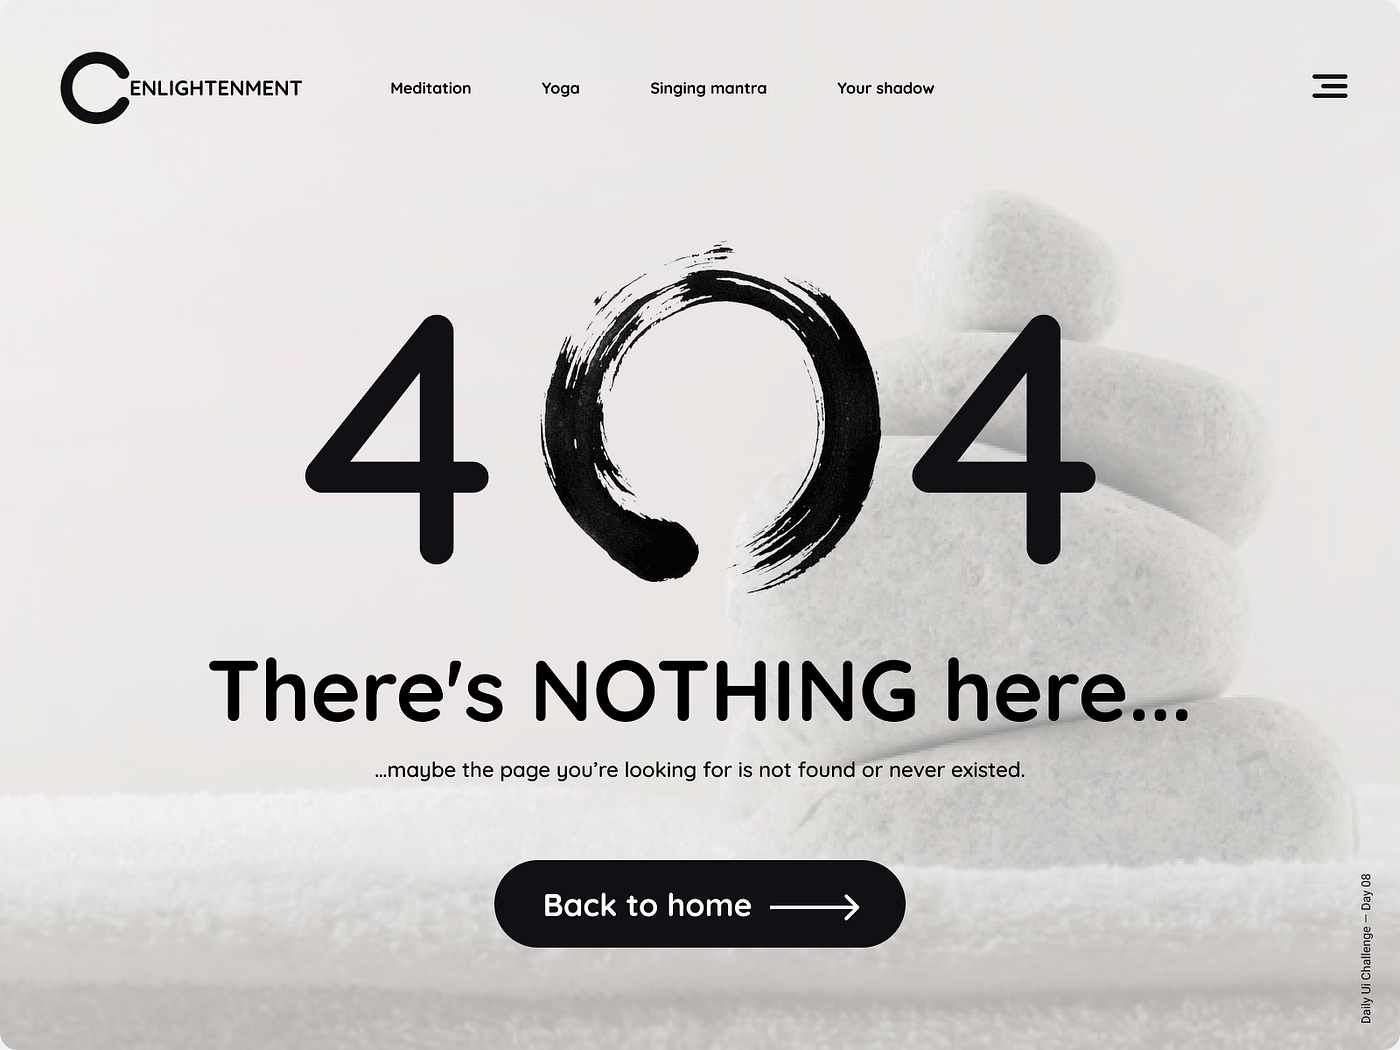

In [4]:
# Set up to display inference images 
image_path = "complete_image_set/inference/404.png"
display(Image(filename=image_path))

In [5]:
# Set up to test image carousel 
filenames = [filename for filename in os.listdir(DATA_PATHS["inference_set_dir"]) if filename != ".gitkeep"]
image_index = 0 

image_widget = widgets.Image(format='png', width=300, height=300)

def update_image(index):
    with open(f"{DATA_PATHS['inference_set_dir']}/{filenames[index]}", "rb") as f:
        image_widget.value = f.read()

def on_next_button_clicked(b):
    global image_index 
    image_index = (image_index + 1) % len(filenames)
    update_image(image_index)

update_image(image_index)

next_button = widgets.Button(description='Next')
next_button.on_click(on_next_button_clicked)

layout = widgets.VBox([image_widget, next_button])
display(layout)

In [6]:
# Set up to append captions to a selected list of captions 
text_box = widgets.Text()
button = widgets.Button(description="Add")
output_widget = widgets.Output()

values_list = []

def on_button_clicked(b):
    with output_widget:
        clear_output()
        value = text_box.value
        values_list.append(value)
        print("Value appended:", value)

button.on_click(on_button_clicked)

def print_list():
    with output_widget:
        clear_output()
        print("Values list:", values_list)

print_button = widgets.Button(description="Print List")
print_button.on_click(lambda b: print_list())

enter_caption_widget = widgets.HBox([text_box, button, print_button])

layout = widgets.VBox([enter_caption_widget, output_widget])
display(layout)


In [7]:
# Set up to edit button text 
def on_button_clicked(b):
    with output_widget:
        clear_output()
        value = text_box.value
        button.description = value

text_box = widgets.Text()
button = widgets.Button(description="Change button text")
output_widget = widgets.Output()

button.on_click(on_button_clicked)

display(widgets.HBox([text_box, button, output_widget]))

In [8]:
# Set up to test multiple output widgets 
def on_button_clicked(b):
    with output_widget:
        clear_output()
        print(text_box.value)

def on_button_2_clicked(b): 
    with output_widget_2: 
        clear_output()
        print(text_box_2.value)

text_box = widgets.Text(description="Enter text:")
button = widgets.Button(description="Get Output")

output_widget = widgets.Output()
output_widget_2 = widgets.Output() 

text_box_2 = widgets.Text(description="More text: ") 
button_2 = widgets.Button(description="Next button") 

hbox_1 = widgets.HBox([text_box_2, button_2, output_widget_2])
hbox_2 = widgets.HBox([text_box, button, output_widget]) 

button.on_click(on_button_clicked)
button_2.on_click(on_button_2_clicked) 

display(widgets.VBox([hbox_1, hbox_2]))

#### Combining script setup

In [5]:
model_configs = {
    "blip": {
        "saved_checkpoint": "models/blip/",
        "processor": BlipProcessor, 
        "pretrained_path": "Salesforce/blip-image-captioning-large", 
        "inference_model": BlipForConditionalGeneration
    }, 
    "vit": {
        "saved_checkpoint": "models/vit/",
        "processor": [ViTImageProcessor, AutoProcessor], 
        "pretrained_path": ["nlpconnect/vit-gpt2-image-captioning", "microsoft/git-large"], 
        "inference_model": AutoModelForCausalLM
    }, 
    "git": {
        "saved_checkpoint": "models/git/",
        "processor": AutoProcessor, 
        "pretrained_path": "microsoft/git-base", 
        "inference_model": AutoModelForCausalLM
    }
}


In [6]:
def load_models(model_configs):
    models = dict.fromkeys(list(model_configs.keys()), {})
    for model_name in model_configs.keys(): 
        ckpt, processor, pretrained_path, inf_model = model_configs[model_name].values()
        models[model_name]["model"] = inf_model.from_pretrained(ckpt)
        models[model_name]["processor"] = [processor[0].from_pretrained(pretrained_path, kwargs="padding"), processor[1].from_pretrained(pretrained_path, kwargs="padding")] if model_name == "vit" else processor.from_pretrained(pretrained_path, kwargs="padding") 

    return models

In [7]:
def generate_captions(models, image):
    captions = [] 
    image_processor = None 
    print("Generating captions....") 
    for model_name in models.keys(): 
        model, processor = models[model_name].values()
        
        if model_name == "vit": 
            image_processor, processor = processor
            
        pixel_values = image_processor(images=image, return_tensors="pt").pixel_values if image_processor else processor(images=image, return_tensors="pt").pixel_values
    
        generated_ids = model.generate(pixel_values=pixel_values, max_length=200, num_return_sequences=1, top_k=100, do_sample=True, temperature=0.8)
        captions.extend(processor.batch_decode(generated_ids, skip_special_tokens=True))

        print(captions) 
    return captions 

In [8]:
# models = load_models(model_configs=model_configs)
filenames = [file for file in os.listdir(DATA_PATHS["inference_set_dir"]) if file != '.gitkeep']

global EDIT_MODE, image_widget, generated_list, selected  
EDIT_MODE = False
generated_list = [] 
selected = []

def update_edit_mode(b):
    global EDIT_MODE
    with output: 
        EDIT_MODE = not(EDIT_MODE)
        if EDIT_MODE: 
            button_edit.description = "Turn off edit mode" 
        else: 
            button_edit.description = "Turn on edit mode" 

def display_image(image_index):
    with img_output:
        clear_output(wait=True)
        with open(f"{DATA_PATHS['inference_set_dir']}/{filenames[image_index]}", "rb") as f: 
            image=f.read() 
        return widgets.Image(value=image, format="png", width=500, height=300)

def on_next(b):
    global current_image_index, generated_list, selected  
    current_image_index = (current_image_index + 1) % len(filenames)
    with output: 
        clear_output(wait=True)
        generated_list = [] 
        printed_container.children = [print_generated()]
    with selected_output: 
        clear_output(wait=True)
        selected = []
        printed_container_layout.layout.visibility = 'hidden'
        selected_container_layout.layout.visibility = 'hidden'
        selected_container.children = [print_selected()]
    with img_output:
        clear_output(wait=True)
        button_create_file.layout = widgets.Layout(display='none')
        image_widget.value = open(image_path + filenames[current_image_index], 'rb').read()
        display(image_widget)

def select_captions(cap): 
    global caption 
    caption = cap 
    with selected_output:
        if EDIT_MODE: 
            text_box.value = cap.description
        else: 
            selected.append(cap.description)
            generated_list.remove(cap.description)
            printed_container.children = [print_generated()]
            selected_container.children = [print_selected()]

def on_generate(b): 
    global generated_list 
    with output: 
        print("Loading captions...." )
        img = IMG.open(image_path + filenames[current_image_index]).convert("RGB")
        generated_list = generated_list + [element for element in generate_captions(models, img) if element not in generated_list]
        clear_output()
        printed_container.children = [print_generated()]

def on_create_file(b): 
    with output: 
        with open(f"{DATA_PATHS['annotated_set_dir']}{filenames[current_image_index].split('.')[0]}.txt", "w") as file: 
            file.writelines("%s\n" % string for string in selected)

        print("File created") 

def print_generated(b=None): 
    tiles = []
    with output:
        clear_output(wait=True)
        printed_container_layout.layout.visibility = 'visible'
        selected_container_layout.layout.visibility = 'visible'
        for string in generated_list:
            tile = widgets.Button(description=string, layout=widgets.Layout(width='auto', height='auto'))
            tile.on_click(select_captions)
            tiles.append(tile)

        return widgets.VBox(tiles)

def undo_selection(b):
    with selected_output:
        clear_output()
        selected.remove(b.description)
        generated_list.append(b.description) 
        printed_container.children = [print_generated()]
        selected_container.children = [print_selected()]

def print_selected(b=None): 
    selected_tiles = [] 
    with selected_output: 
        clear_output(wait=True)
        button_create_file.layout = widgets.Layout(width='100%')
        for caption in selected: 
            tile = widgets.Button(description=caption, layout=widgets.Layout(width='auto', height='auto'))
            tile.on_click(undo_selection)
            selected_tiles.append(tile) 

        return widgets.VBox(selected_tiles) 

def on_add_prompt(b):
    with output: 
        if EDIT_MODE:
            generated_list.remove(caption.description)
            caption.description = text_box.value 
            selected.append(text_box.value) 
        else:
            value = text_box.value
            selected.append(value)
        
        text_box.value = ''
        printed_container.children = [print_generated()]
        selected_container.children = [print_selected()]

# widgets 
global printed_container_layout, selected_container_layout, button_create_file, generated_section_label, selected_section_label

# Initial index
current_image_index = 0

# Defining output widgets 
img_output = widgets.Output() 
selected_output = widgets.Output() 
output = widgets.Output()

display(output)
display(selected_output)

# Defining buttons 
button_next = widgets.Button(description="Next", layout=widgets.Layout(width='100%'))
button_generate = widgets.Button(description="Generate", layout=widgets.Layout(width='100%')) 
button_create_file = widgets.Button(description="Create File", layout=widgets.Layout(width='100%'))
button_edit = widgets.Button(description="Turn on Edit mode", layout=widgets.Layout(width='100%')) 

# Text box to add any prompts
text_box = widgets.Textarea(value='', layout=widgets.Layout(width='100%', height='auto'))
button_add = widgets.Button(description="Add", layout=widgets.Layout(height='auto'))

# Display image 
image_widget = display_image(current_image_index)

# Defining the interface layout
button_create_file.layout = widgets.Layout(display='none')
buttons_layout = widgets.HBox([button_next, button_generate, button_edit, button_create_file])
add_caption_layout = widgets.HBox([text_box, button_add])

control_panel_layout = widgets.VBox([buttons_layout, add_caption_layout])

generated_section_label = widgets.HTML(value="<h3>Generated captions</h3>")
selected_section_label = widgets.HTML(value="<h3>Selected captions</h3>")

printed_container = widgets.VBox([]) 
selected_container = widgets.VBox([]) 

printed_container_layout = widgets.VBox([generated_section_label, printed_container])
printed_container_layout.layout.width = '50%'
printed_container_layout.layout.visibility = 'hidden'
selected_container_layout = widgets.VBox([selected_section_label, selected_container])
selected_container_layout.layout.width = '50%'
selected_container_layout.layout.visibility = 'hidden'
captions_layout = widgets.HBox([printed_container_layout, selected_container_layout]) 

# Linking buttons to defined functions
button_next.on_click(on_next)
button_generate.on_click(on_generate)
button_edit.on_click(update_edit_mode) 
button_create_file.on_click(on_create_file)
button_add.on_click(on_add_prompt)

layout = widgets.VBox([image_widget, control_panel_layout, captions_layout])
display(layout)

Output()

Output()